In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

In [2]:
images = glob('/content/drive/MyDrive/SkinCancerDetection/train_cancer/*/*.jpg')
print(f"Total Images Found: {len(images)}") #glob use hota hai jab humy multiple folders ko 1 folder me filter/access karna ho

Total Images Found: 270


In [3]:
#replace backslash with forward slash to avoid unexpected errors
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].apply(lambda x: x.split('/')[-2] if len(x.split('/')) > 2 else 'Unknown')

df.head()

,filepath,label
0,/content/drive/MyDrive/SkinCancerDetection/tra...,benign
1,/content/drive/MyDrive/SkinCancerDetection/tra...,benign
2,/content/drive/MyDrive/SkinCancerDetection/tra...,benign
3,/content/drive/MyDrive/SkinCancerDetection/tra...,benign
4,/content/drive/MyDrive/SkinCancerDetection/tra...,benign


In [4]:
#es me malignant aur benign binary format me convert ho rahy hain
df['label_bin'] = df['label'].map({'malignant': 1, 'benign': 0})
df.head() #always shows first 5 entries from dataset

,filepath,label,label_bin
0,/content/drive/MyDrive/SkinCancerDetection/tra...,benign,0
1,/content/drive/MyDrive/SkinCancerDetection/tra...,benign,0
2,/content/drive/MyDrive/SkinCancerDetection/tra...,benign,0
3,/content/drive/MyDrive/SkinCancerDetection/tra...,benign,0
4,/content/drive/MyDrive/SkinCancerDetection/tra...,benign,0


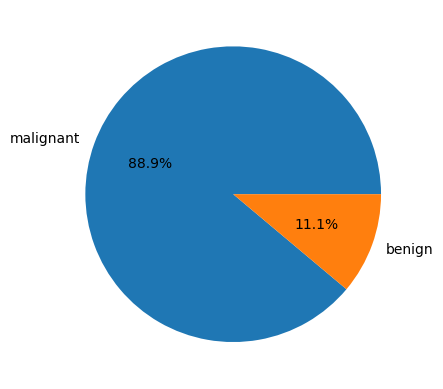

In [5]:
x = df['label'].value_counts()
plt.pie(x.values,
		labels=x.index,
		autopct='%1.1f%%')
plt.show()

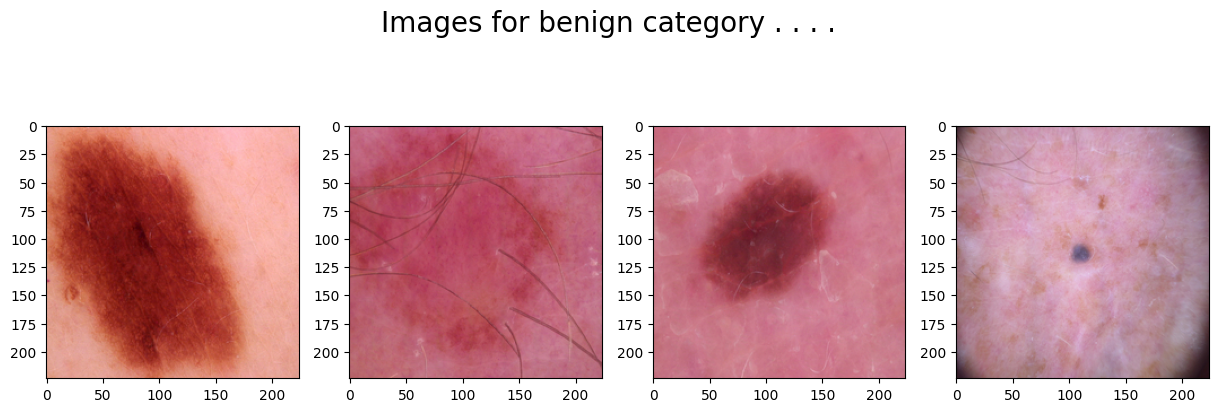

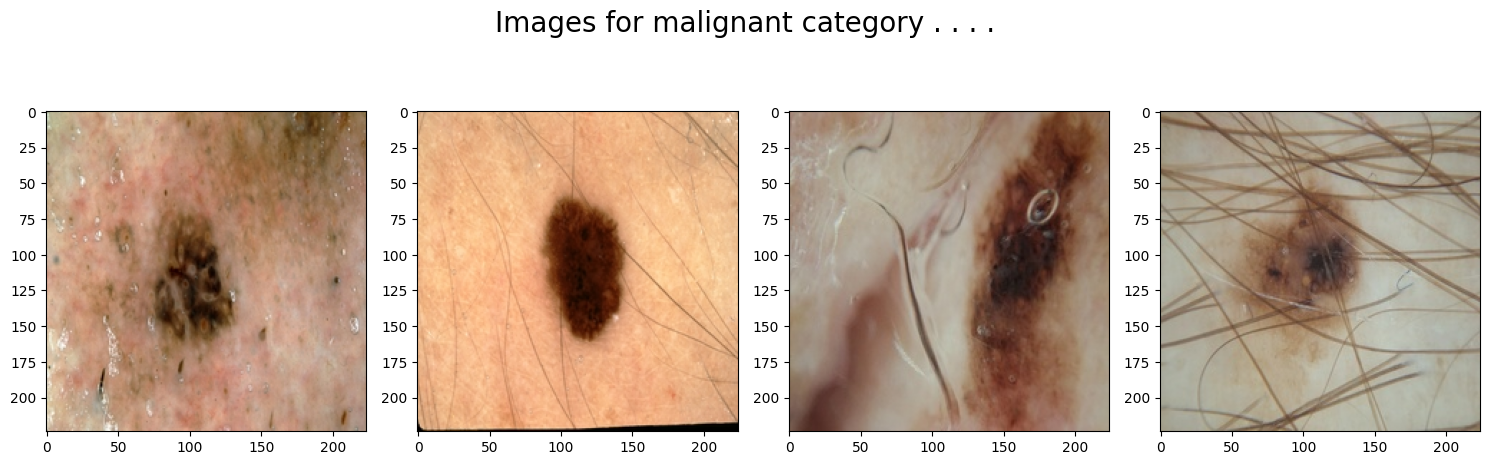

In [6]:
for cat in df['label'].unique():
	temp = df[df['label'] == cat]

	index_list = temp.index
	fig, ax = plt.subplots(1, 4, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
	for i in range(4):
		index = np.random.randint(0, len(index_list))
		index = index_list[index]
		data = df.iloc[index]

		image_path = data[0]

		img = np.array(Image.open(image_path))
		ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [7]:
#perform dataset splitting
features = df['filepath']
target = df['label_bin']

X_train, X_val,	Y_train, Y_val = train_test_split(features, target,
									test_size=0.15,
									random_state=10)

X_train.shape, X_val.shape

((229,), (41,))

In [8]:
#Images ki preprocessing ho rahi hai tensorflow k leay
def decode_image(filepath, label=None):

	img = tf.io.read_file(filepath)
	img = tf.image.decode_jpeg(img)
	img = tf.image.resize(img, [224, 224])
	img = tf.cast(img, tf.float32) / 255.0

	if label == 0:
		Label = 0
	else:
		Label = 1

	return img, Label

# Dataset ko tensorflow k leay ready kar raha hai
train_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_train, Y_train))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO) #Next batch ko pehlay sy memory me load kr k rakhta hai ta k GPU TPU ko wait na karna parhy
)

val_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_val, Y_val))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

In [23]:
#pretrained EfficientNet model use ho raha hai jo imagenet k dataset pr tarined hain it is transfer learning
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pre_trained_model = EfficientNetB7(
	input_shape=(224, 224, 3), #RGB image dy rahy hain input k tor pr
	weights='imagenet', #weights imagenet k use kary ga
	include_top=False #Fully connected layer freeze krdi hai ta k sirf features extract hon
)

for layer in pre_trained_model.layers:
	layer.trainable = False # yahn par sari layers freeze ho rahi hain ta k existing features he use kary

In [24]:
from tensorflow.keras import Model

inputs = layers.Input(shape=(224, 224, 3))
x = layers.GlobalAveragePooling2D()(inputs)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [25]:
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer='adam',
	metrics=['AUC']
)

In [26]:
history = model.fit(train_ds,
					validation_data=val_ds,
					epochs=10,
					verbose=1)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step - AUC: 0.7973 - loss: 0.6710 - val_AUC: 0.6081 - val_loss: 0.6408
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - AUC: 0.9770 - loss: 0.4945 - val_AUC: 0.8041 - val_loss: 0.5853
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - AUC: 0.9892 - loss: 0.3929 - val_AUC: 0.7095 - val_loss: 0.5309
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - AUC: 0.9745 - loss: 0.3564 - val_AUC: 0.7297 - val_loss: 0.5013
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - AUC: 0.9686 - loss: 0.3200 - val_AUC: 0.6250 - val_loss: 0.4652
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - AUC: 0.9698 - loss: 0.3033 - val_AUC: 0.6419 - val_loss: 0.4397
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - AUC: 0.9819 - loss: 0.2365 - val_AUC: 0.6351 - val_loss: 0.4145
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - AUC: 0.9770 - loss: 0.2380 - val_AUC: 0.7196 - val_loss: 0.3971
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - AUC: 0.9764 - loss: 0.2302

In [27]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,AUC,loss,val_AUC,val_loss
0,0.879973,0.615208,0.608108,0.640813
1,0.976317,0.481557,0.804054,0.585332
2,0.987306,0.399367,0.709459,0.530854
3,0.961065,0.374997,0.729730,0.501278
4,0.958791,0.322645,0.625000,0.465172


In [28]:
model.save('my_model.keras')  # HDF5 format me save karega


In [29]:
print(type(Y_val))
print(Y_val[:5])  # Pehli 5 values dekhein

<class 'pandas.core.series.Series'>
111    1
170    1
106    1
105    1
121    1
Name: label_bin, dtype: int64


In [30]:
#Inference
# Model se prediction lena
predictions = model.predict(val_ds)

# Convert Predictions to Binary (0 = Benign, 1 = Malignant)
predicted_labels = (predictions > 0.6).astype(int)

# Actual vs Predicted Comparison
#for i in range(5):  # Pehli 5 images ka comparison karein
for i in range(5,10):
    actual = "Malignant" if Y_val.iloc[i] == 1 else "Benign"
    predicted = "Malignant" if predicted_labels[i] == 1 else "Benign"

    print(f"Image {i+1}: Actual = {actual} | Predicted = {predicted}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step
Image 6: Actual = Malignant | Predicted = Malignant
Image 7: Actual = Malignant | Predicted = Malignant
Image 8: Actual = Malignant | Predicted = Malignant
Image 9: Actual = Malignant | Predicted = Malignant
Image 10: Actual = Malignant | Predicted = Malignant


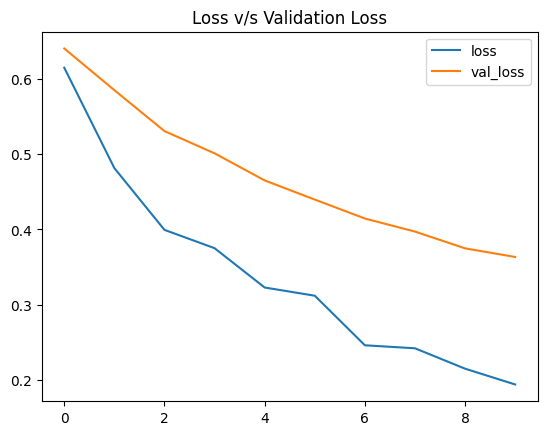

In [31]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()

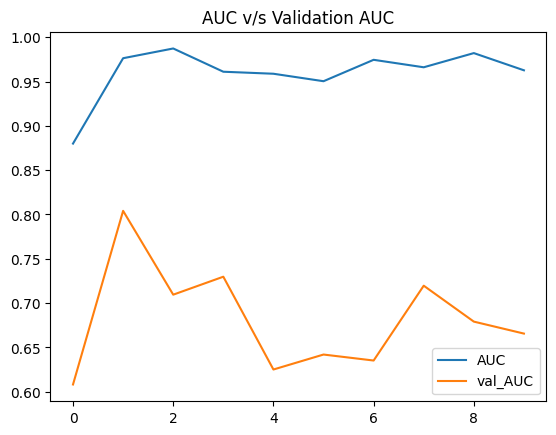

In [32]:
hist_df['AUC'].plot()
hist_df['val_AUC'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()